In [1]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

import sys
sys.path.append("../../")
from utils import metrics
from utils.logger import Logger
import logging

device = "cuda" if torch.cuda.is_available() else "gpu"
print(f"Using device: {device}.")

Using device: cuda.


In [2]:
# CNN 网络模型
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 15), stride=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 15), stride=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 15), stride=1),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 15), stride=1),
            nn.ReLU(inplace=True)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16 * 3 * 17, out_features=50),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=50, out_features=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
model = LeNet5().to(device)
summary(model, (1, 3, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 3, 211]             256
              ReLU-2           [-1, 16, 3, 211]               0
         MaxPool2d-3           [-1, 16, 3, 105]               0
              ReLU-4           [-1, 16, 3, 105]               0
            Conv2d-5            [-1, 32, 3, 91]           7,712
              ReLU-6            [-1, 32, 3, 91]               0
         MaxPool2d-7            [-1, 32, 3, 45]               0
              ReLU-8            [-1, 32, 3, 45]               0
            Conv2d-9            [-1, 16, 3, 31]           7,696
             ReLU-10            [-1, 16, 3, 31]               0
           Conv2d-11            [-1, 16, 3, 17]           3,856
             ReLU-12            [-1, 16, 3, 17]               0
           Linear-13                   [-1, 50]          40,850
             ReLU-14                   

In [3]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

In [4]:
# 自定义电池数据集
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sequence, target = self.data[index]
        return torch.tensor(sequence, dtype=torch.float32).reshape(1, 3, 225), torch.tensor([target], dtype=torch.float32)

In [5]:
# 读取数据
data_path = "../../data/processed_data/tri/vit/"
data_files = sorted(glob.glob(os.path.join(data_path, "*.npy")))

for data_file in data_files:
    print(data_file)

# load_data_test = np.load(data_files[0], allow_pickle=True)
# print(type(load_data_test), load_data_test.shape) # <class 'numpy.ndarray'> (11903, 2)
# print(load_data_test[0][0].shape, load_data_test[0][1].shape) # (3, 225) ()

# print(np.load(data_files[0], allow_pickle=True).shape[0] + np.load(data_files[1], allow_pickle=True).shape[0])
# dataset_test = []
# for i in range(2):
#     dataset_test += np.load(data_files[i], allow_pickle=True).tolist()
# print(len(dataset_test))

# 电池组编号和电池编号的映射
battery_map = {0: [0, 1, 2, 3], 1: [4, 5, 6, 7], 2: [8, 9, 10, 11], 3: [12, 13, 14, 15]}

../../data/processed_data/tri/vit/b3c00.npy
../../data/processed_data/tri/vit/b3c01.npy
../../data/processed_data/tri/vit/b3c02.npy
../../data/processed_data/tri/vit/b3c03.npy
../../data/processed_data/tri/vit/b3c04.npy
../../data/processed_data/tri/vit/b3c05.npy
../../data/processed_data/tri/vit/b3c06.npy
../../data/processed_data/tri/vit/b3c07.npy
../../data/processed_data/tri/vit/b3c08.npy
../../data/processed_data/tri/vit/b3c09.npy
../../data/processed_data/tri/vit/b3c10.npy
../../data/processed_data/tri/vit/b3c11.npy
../../data/processed_data/tri/vit/b3c12.npy
../../data/processed_data/tri/vit/b3c13.npy
../../data/processed_data/tri/vit/b3c14.npy
../../data/processed_data/tri/vit/b3c15.npy


In [6]:
# 划分训练集和测试集
def get_train_test_dataset(experiment_id, train_group, test_group, logger):
    
    # 训练/测试电池编号
    train_batteries = [battery for group in train_group for battery in battery_map[group]]
    test_batteries = battery_map[test_group]

    # 输出实验信息到日志
    # print(f"experiment id: {experiment_id + 1}")
    # print(f"training dataset batteries index: {train_batteries}")
    # print(f"testing dataset batteries index: {test_batteries}")
    logger.info(f"experiment id: {experiment_id + 1}")
    logger.info(f"training dataset batteries index: {train_batteries}")
    logger.info(f"testing dataset batteries index: {test_batteries}")
    
    train_dataset = []
    test_dataset = []

    # 合并成一个数据集
    for i in train_batteries:
        # print(data_files[i])
        train_dataset += np.load(data_files[i], allow_pickle=True).tolist()
    # 不合并成一个数据集
    for j in test_batteries:
    #     # print(data_files[j])
        test_dataset.append(np.load(data_files[j], allow_pickle=True).tolist())
        # test_dataset += np.load(data_files[j], allow_pickle=True).tolist()
        
    train_dataset = BatteryDataset(train_dataset)

    return train_dataset, test_dataset

2023-05-16 13:14:08,783 - tri_vit_cnn - INFO - experiment id: 1
2023-05-16 13:14:08,783 - tri_vit_cnn - INFO - training dataset batteries index: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2023-05-16 13:14:08,784 - tri_vit_cnn - INFO - testing dataset batteries index: [0, 1, 2, 3]


Save log to: ../../logs/2023_05_16_13_14_tri_vit_cnn.log


2023-05-16 13:14:09,676 - tri_vit_cnn - INFO - dataloader info: shape of X is torch.Size([128, 1, 3, 225]), shape of y is torch.Size([128, 1])
2023-05-16 13:14:09,679 - tri_vit_cnn - INFO - 训练开始
2023-05-16 13:15:17,808 - tri_vit_cnn - INFO - epoch 10, train loss 0.00027197989894894864, validation loss 0.0
2023-05-16 13:15:17,810 - tri_vit_cnn - INFO - model save to path: ../../checkpoints/tri_vit_cnn/group1_epoch10.pth
2023-05-16 13:16:26,076 - tri_vit_cnn - INFO - epoch 20, train loss 0.0001380694541615068, validation loss 0.0
2023-05-16 13:16:26,077 - tri_vit_cnn - INFO - model save to path: ../../checkpoints/tri_vit_cnn/group1_epoch20.pth
2023-05-16 13:17:33,044 - tri_vit_cnn - INFO - epoch 30, train loss 9.466133473812651e-05, validation loss 0.0
2023-05-16 13:17:33,045 - tri_vit_cnn - INFO - model save to path: ../../checkpoints/tri_vit_cnn/group1_epoch30.pth
2023-05-16 13:18:41,381 - tri_vit_cnn - INFO - epoch 40, train loss 7.023108676348992e-05, validation loss 0.0
2023-05-16 1

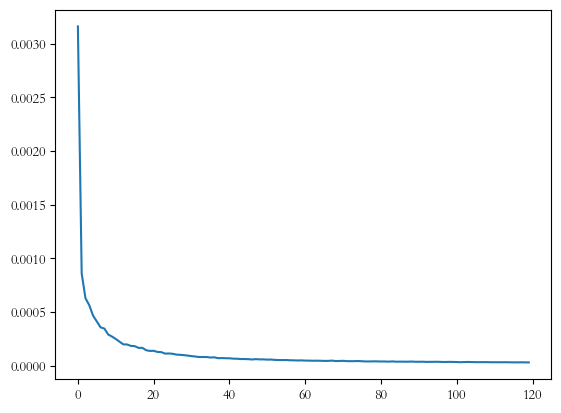

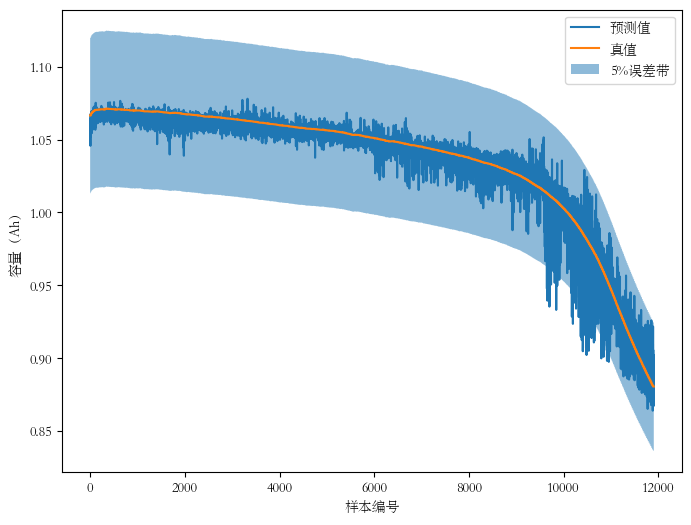

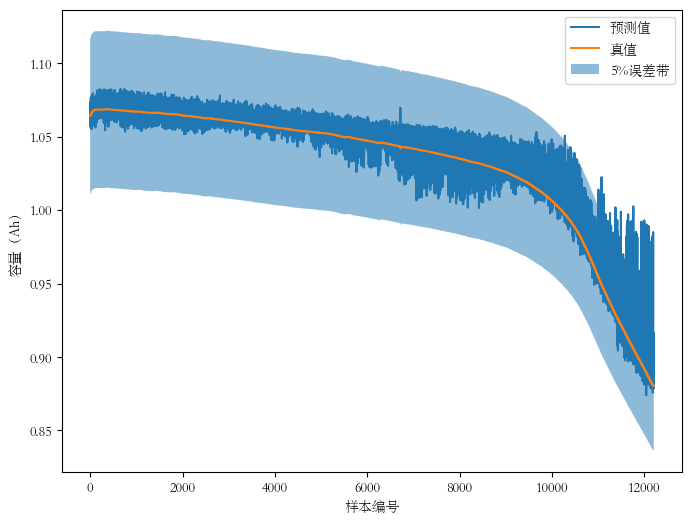

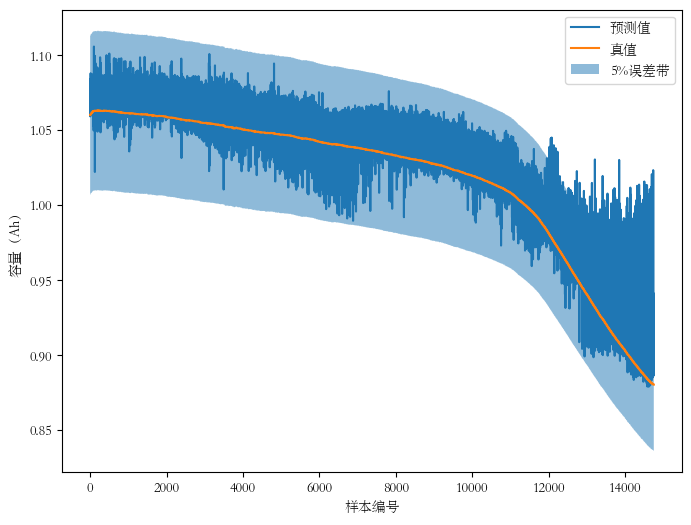

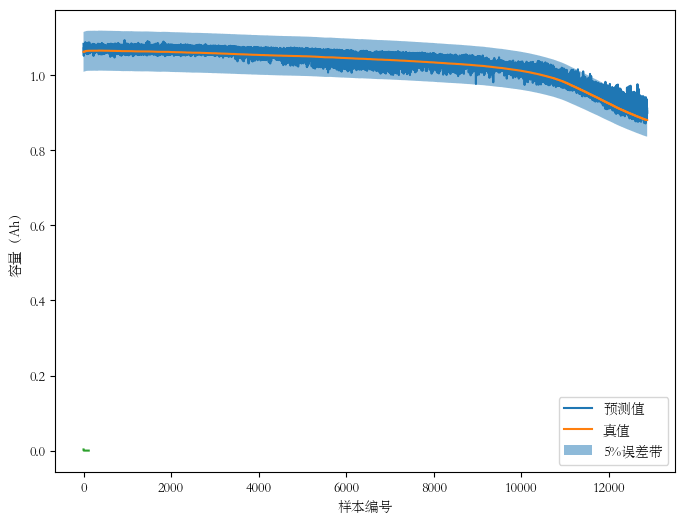

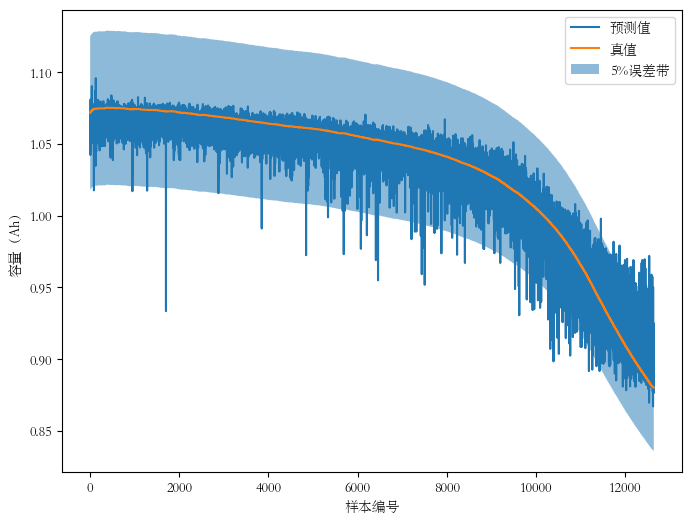

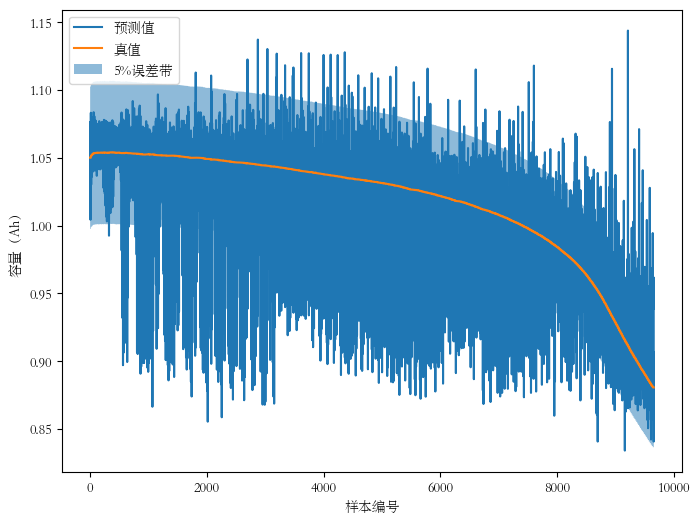

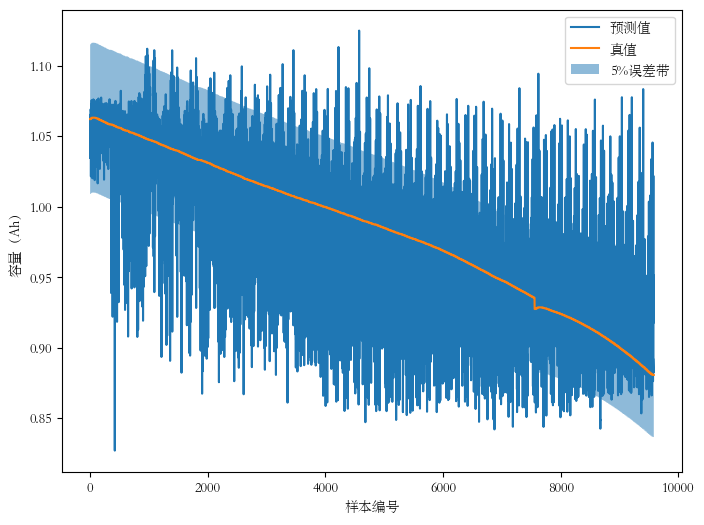

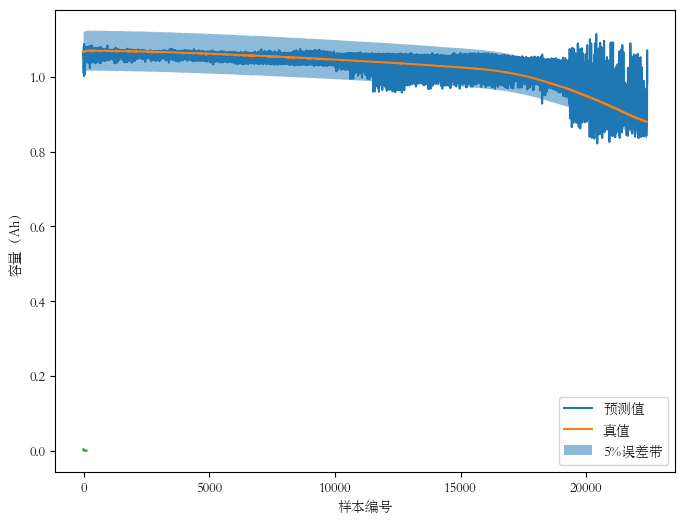

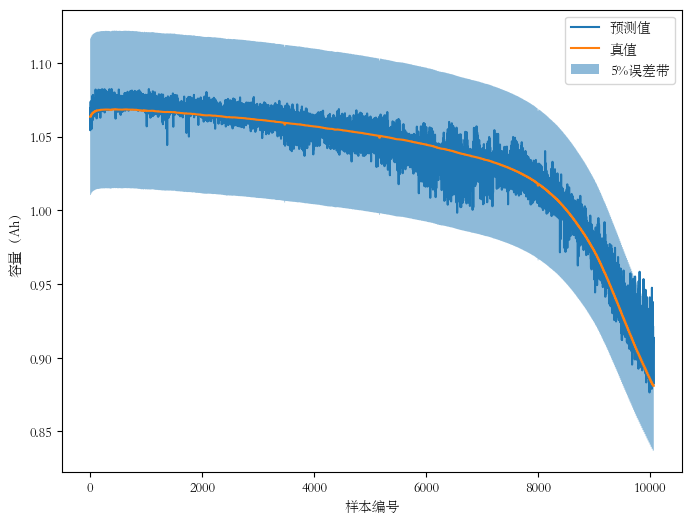

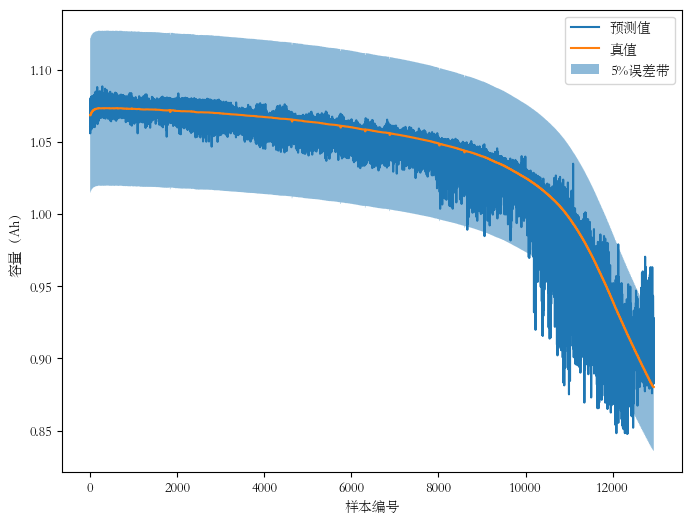

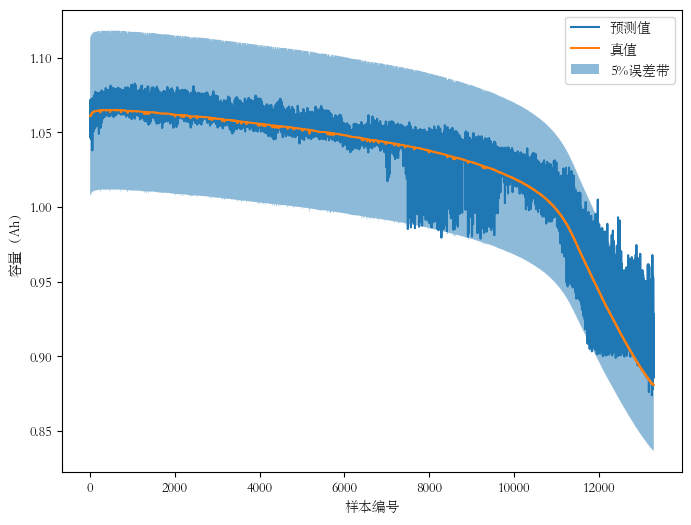

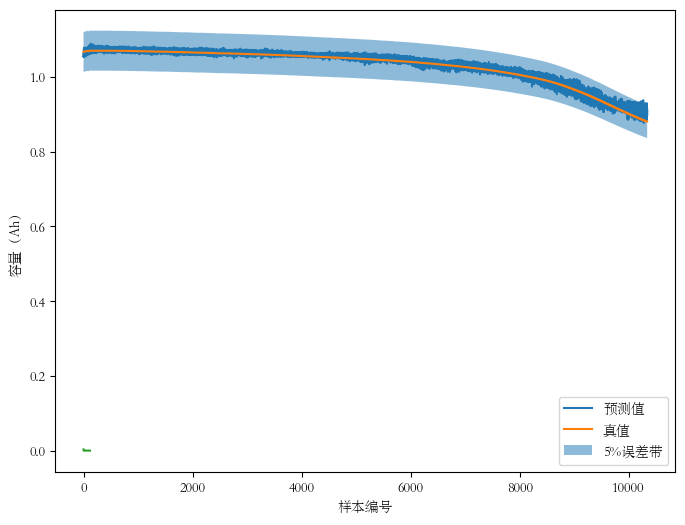

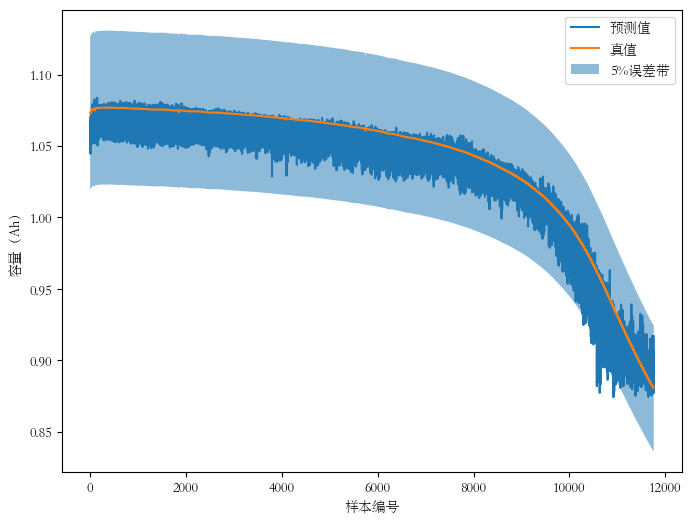

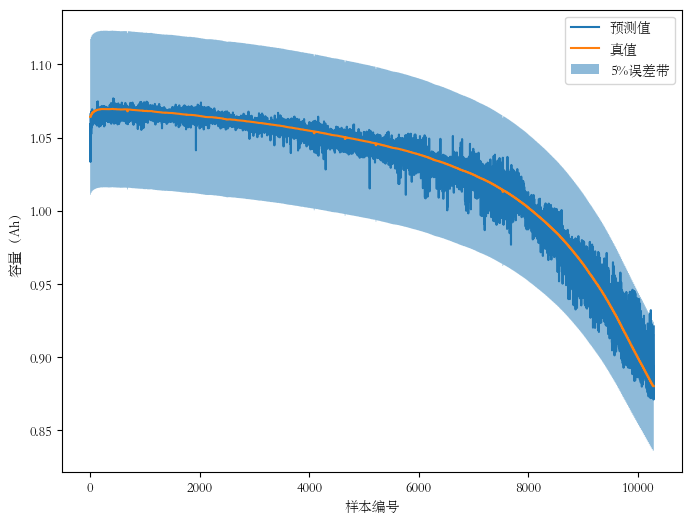

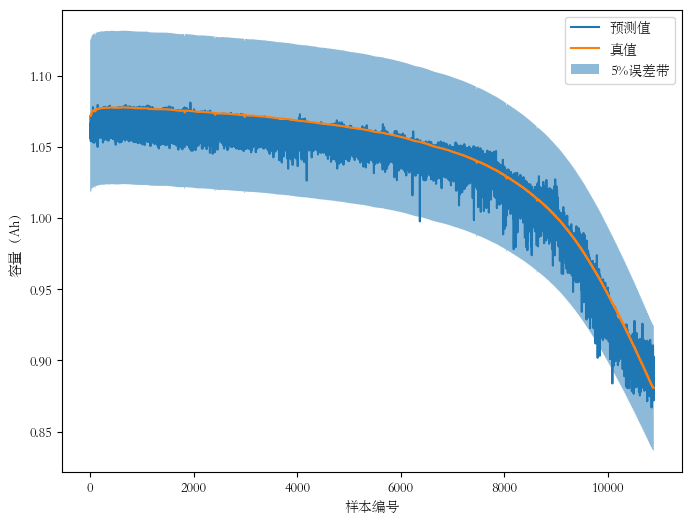

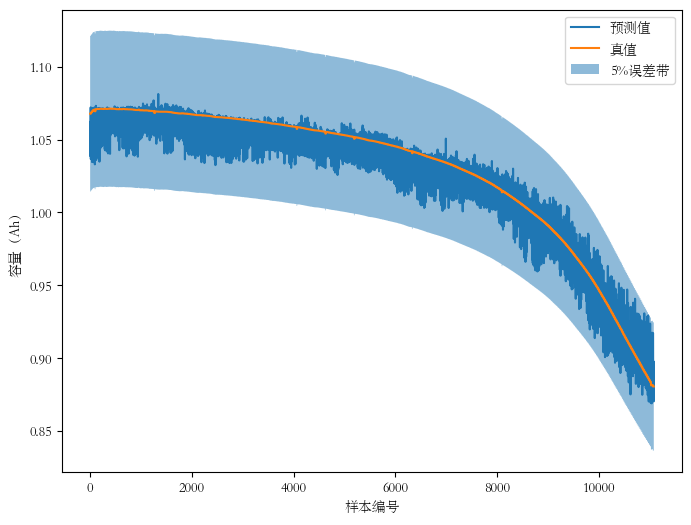

In [7]:
logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="tri_vit_cnn"
    ).get_logger()

# 16块电池分为4组，共进行4组实验
num_cells = 16
num_groups = 4
num_experiments = num_groups
num_cells_per_group = num_cells // num_groups

lr = 1e-3
epochs = 120

# 四组实验
for i in range(num_experiments):

    experiment_id = i
    test_group = i
    train_groups = [group for group in battery_map.keys() if group != test_group]

    train_dataset, test_dataset = get_train_test_dataset(experiment_id, train_groups, test_group, logger)

    batch_size = 128
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    X, y = next(iter(train_dataloader))
    # print(f"dataloader info: shape of X is {X.shape}, shape of y is {y.shape}")
    logger.info(f"dataloader info: shape of X is {X.shape}, shape of y is {y.shape}")

    torch.manual_seed(3407)
    model = LeNet5().to(device)
    model.apply(weight_init)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 模型训练
    train_losses, val_losses = [], []
    # print("开始训练")
    logger.info("训练开始")
    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0.0, 0.0
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            # print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")
            logger.info(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")
            model_root_path = "../../checkpoints/tri_vit_cnn"
            model_save_path = os.path.join(model_root_path, f"group{experiment_id + 1}_epoch{epoch + 1}.pth")
            # print(f"model save to path: {model_save_path}")
            logger.info(f"model save to path: {model_save_path}")
            torch.save(model.state_dict(), model_save_path)

    # print("训练完成")
    logger.info("训练完成")

    plt.plot(train_losses)


    # 模型评估
    for k in range(num_cells_per_group):
        test_dataset_single = test_dataset[k]
        test_dataset_single = BatteryDataset(test_dataset_single)
        gt, pred = [], []

        for X, y in test_dataset_single:
            gt.append(float(y))
            pred.append(float(model(X.to(device))))

        pred = np.array(pred)
        gt = np.array(gt)
        cycle = np.arange(len(gt))
        y1 = gt * (1 + 0.05)
        y2 = gt * (1 - 0.05)

        plt.figure(figsize=(8, 6))
        plt.plot(pred)
        plt.plot(gt)
        plt.fill_between(cycle, y2, y1, alpha=0.5)
        plt.legend(["预测值", "真值", "5%误差带"])
        plt.xlabel("样本编号")
        plt.ylabel("容量（Ah）")
        save_path = f"../../assets/thesis_figures/chapter_4/tri_group{experiment_id + 1}_cell{k + 1}_cnn_vit.jpg"
        plt.savefig(save_path, dpi=1000, bbox_inches="tight")

        maxE, mae, rmse = metrics.evaluation(gt, pred)
        logger.info(f"maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")